In [2]:
import pandas as pd
from rich import print
import warnings
import xarray as xr
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

import pickle as pkl


In [3]:
energy_data = pd.read_csv("source\Energy_Data_20200920_20240118.csv")
dwd_solar = xr.open_dataset("source\dwd_icon_eu_TEST\dwd_icon_eu_pes10_20231027_20240108.nc")
dwd_solar_train = xr.open_dataset("source\dwd_icon_eu_TRAIN\dwd_icon_eu_pes10_20200920_20231027.nc")
dwd_solar.head()

<xarray.Dataset> Size: 2kB
Dimensions:                 (valid_time: 5, reference_time: 5, point: 5)
Coordinates:
  * valid_time              (valid_time) int64 40B 0 1 2 3 4
    latitude                (point) float64 40B ...
    longitude               (point) float64 40B ...
  * point                   (point) int64 40B 0 1 2 3 4
  * reference_time          (reference_time) datetime64[ns] 40B 2023-10-27 .....
Data variables:
    CloudCover              (reference_time, valid_time, point) float32 500B ...
    SolarDownwardRadiation  (reference_time, valid_time, point) float64 1kB ...
    Temperature             (reference_time, valid_time, point) float32 500B ...

In [7]:
solar_radiation = dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
temperature = dwd_solar["Temperature"].mean(dim="point").to_dataframe().reset_index()
cloud_cover = dwd_solar["CloudCover"].mean(dim="point").to_dataframe().reset_index()

dwd_solar_features = pd.merge(solar_radiation, temperature, on=["reference_time", "valid_time"])
dwd_solar_features = pd.merge(dwd_solar_features, cloud_cover, on=["reference_time", "valid_time"])
dwd_solar_features = dwd_solar_features[ dwd_solar_features["valid_time"] != 120 ]
dwd_solar_features["reference_time"] = dwd_solar_features["reference_time"].dt.tz_localize("UTC")
dwd_solar_features["added_time"] = dwd_solar_features["reference_time"] + pd.TimedeltaIndex(dwd_solar_features["valid_time"],unit="hours")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
modelling_table = dwd_solar_features
modelling_table = modelling_table.set_index("added_time").groupby("reference_time").resample("30T").interpolate("linear")
modelling_table = modelling_table.drop(columns="reference_time").reset_index()
modelling_table = modelling_table.merge(energy_data,how="inner",left_on="added_time",right_on="dtm")
modelling_table = modelling_table[modelling_table["added_time"] - modelling_table["reference_time"] < np.timedelta64(50,"h")]

modelling_table = modelling_table.drop(columns=['MIP', 'SS_Price', 'DA_Price', 'Wind_MW', 'boa_MWh', "reference_time", "valid_time"])
modelling_table = modelling_table.groupby(by="added_time").mean().reset_index()
modelling_table = modelling_table.sort_values(by="added_time")
modelling_table.to_csv("energy_data\clean_solar_energy_test.csv")
modelling_table.head()

,added_time,SolarDownwardRadiation,Temperature,CloudCover,dtm,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp
0,2023-10-27 00:00:00+00:00,0.0,8.954315,0.641780,2023-10-27 00:00:00+00:00,0.0,2453.150623,2609.200511
1,2023-10-27 00:30:00+00:00,0.0,8.843015,0.686105,2023-10-27 00:30:00+00:00,0.0,2453.150623,2609.200511
2,2023-10-27 01:00:00+00:00,0.0,8.731714,0.730430,2023-10-27 01:00:00+00:00,0.0,2453.150623,2609.200511
3,2023-10-27 01:30:00+00:00,0.0,8.593836,0.787374,2023-10-27 01:30:00+00:00,0.0,2453.150623,2609.200511
4,2023-10-27 02:00:00+00:00,0.0,8.455957,0.844317,2023-10-27 02:00:00+00:00,0.0,2453.150623,2609.200511


In [6]:
solar_radiation = dwd_solar_train["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
temperature = dwd_solar_train["Temperature"].mean(dim="point").to_dataframe().reset_index()
cloud_cover = dwd_solar_train["CloudCover"].mean(dim="point").to_dataframe().reset_index()

dwd_solar_train_features = pd.merge(solar_radiation, temperature, on=["ref_datetime", "valid_datetime"])
dwd_solar_train_features = pd.merge(dwd_solar_train_features, cloud_cover, on=["ref_datetime", "valid_datetime"])
dwd_solar_train_features = dwd_solar_train_features[ dwd_solar_train_features["valid_datetime"] != 120 ]
dwd_solar_train_features["ref_datetime"] = dwd_solar_train_features["ref_datetime"].dt.tz_localize("UTC")
dwd_solar_train_features["added_time"] = dwd_solar_train_features["ref_datetime"] + pd.TimedeltaIndex(dwd_solar_train_features["valid_datetime"],unit="hours")
energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])
modelling_table = dwd_solar_train_features
modelling_table = modelling_table.set_index("added_time").groupby("ref_datetime").resample("30T").interpolate("linear")
modelling_table = modelling_table.drop(columns="ref_datetime").reset_index()
modelling_table = modelling_table.merge(energy_data,how="inner",left_on="added_time",right_on="dtm")
modelling_table = modelling_table[modelling_table["added_time"] - modelling_table["ref_datetime"] < np.timedelta64(50,"h")]

modelling_table = modelling_table.drop(columns=['MIP', 'SS_Price', 'DA_Price', 'Wind_MW', 'boa_MWh', "ref_datetime", "valid_datetime"])
modelling_table = modelling_table.groupby(by="added_time").mean().reset_index()
modelling_table.to_csv("energy_data\clean_solar_energy_train.csv")
modelling_table.head()

,added_time,SolarDownwardRadiation,Temperature,CloudCover,dtm,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp
0,2020-09-20 00:00:00+00:00,0.0,13.646173,0.450405,2020-09-20 00:00:00+00:00,0.0,2130.537493,2228.208777
1,2020-09-20 00:30:00+00:00,0.0,13.658508,0.472211,2020-09-20 00:30:00+00:00,0.0,2130.537493,2228.208777
2,2020-09-20 01:00:00+00:00,0.0,13.670843,0.494018,2020-09-20 01:00:00+00:00,0.0,2130.537493,2228.208777
3,2020-09-20 01:30:00+00:00,0.0,13.732101,0.520214,2020-09-20 01:30:00+00:00,0.0,2130.537493,2228.208777
4,2020-09-20 02:00:00+00:00,0.0,13.793360,0.546410,2020-09-20 02:00:00+00:00,0.0,2130.537493,2228.208777


In [5]:
modelling_table.isna().sum()

added_time                     0
SolarDownwardRadiation         0
Temperature                    0
CloudCover                     0
dtm                            0
Solar_MW                       0
Solar_capacity_mwp             0
Solar_installedcapacity_mwp    0
dtype: int64

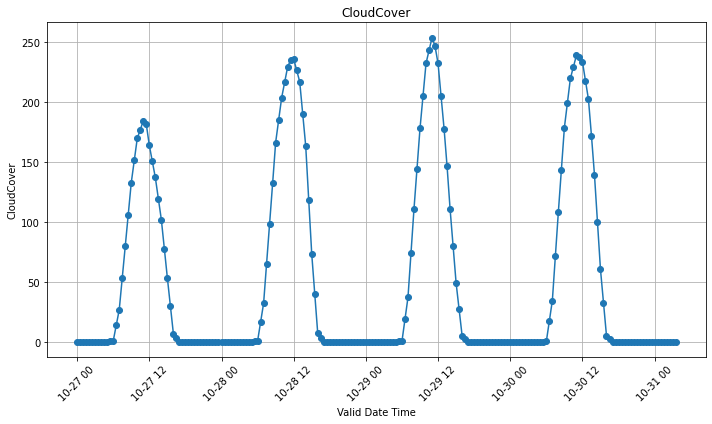

In [8]:
# Convertir les colonnes en numpy array
x = modelling_table["added_time"][:200].to_numpy()
y = modelling_table["SolarDownwardRadiation"][:200].to_numpy()

# Créer le tracé
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.title('CloudCover')
plt.xlabel('Valid Date Time')
plt.ylabel('CloudCover')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Afficher le tracé
plt.show()

In [6]:
modelling_table[ modelling_table["Solar_MW"].isna()]

,added_time,SolarDownwardRadiation,Temperature,CloudCover,dtm,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp
12413,2021-06-07 02:30:00+00:00,0.034613,12.496149,0.587015,2021-06-07 02:30:00+00:00,NaN,2139.084416,2249.529981
12461,2021-06-08 02:30:00+00:00,0.024774,15.990863,0.689658,2021-06-08 02:30:00+00:00,NaN,2139.167734,2249.640963
12701,2021-06-13 02:30:00+00:00,0.057648,12.201800,0.911789,2021-06-13 02:30:00+00:00,NaN,2139.438791,2250.130884
25955,2022-03-16 05:30:00+00:00,9.068794,6.717255,0.658878,2022-03-16 05:30:00+00:00,NaN,2158.390168,2282.786801
29455,2022-05-28 03:30:00+00:00,-0.011200,10.127935,0.981142,2022-05-28 03:30:00+00:00,NaN,2168.569851,2296.659841
31279,2022-07-05 03:30:00+00:00,-0.003351,13.759796,0.112920,2022-07-05 03:30:00+00:00,NaN,2168.288524,2298.274511
39375,2023-01-03 07:30:00+00:00,132.520312,12.122583,0.896537,2023-01-03 07:30:00+00:00,NaN,2262.934824,2402.719735
39376,2023-01-03 08:00:00+00:00,-0.012500,9.394903,0.824779,2023-01-03 08:00:00+00:00,NaN,2262.934824,2402.719735
39392,2023-01-03 16:00:00+00:00,71.299740,8.243977,0.716365,2023-01-03 16:00:00+00:00,NaN,2262.934824,2402.719735
39566,2023-01-07 07:00:00+00:00,0.006836,7.224164,0.677032,2023-01-07 07:00:00+00:00,NaN,2264.157745,2404.153253
